In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import librosa
import pickle
import numpy as np 
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.xmargin"] = 0
plt.rcParams["toolbar"] = "None"  
plt.rcParams["axes.titlesize"] = 10


import tensorflow as tf
import tensorflow.keras as tfk

from ai_edge_litert.interpreter import Interpreter

from utils import get_spectrogram, plot_spectrogram, plot_eval


### Get TF model

In [2]:
with open("GunSound_FCN.pkl", "rb") as f:
    model = pickle.load(f)

model.pop()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 31, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 2)        │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,552 (1.82 MB)

 Trainable params: 158,850 (620.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 317,702 (1.21 MB)

## Get test dataset
Get representative data for quantification analysis

In [3]:
dataset = tf.data.Dataset.load("test_data")


def exp_ds_dim(data, label):
    data = data[..., tf.newaxis]
    return data, label


BATCH_SIZE = 16
labels = ["GUNS", "ENV"]

dataset = dataset.map(exp_ds_dim).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().shuffle(30000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Quantify model and save as .tflite

In [4]:
# First save the original model in .tflite format (no optimizations)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the original model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


# Generate representative data
def representative_data_gen():
    for image_batch, label_batch in dataset.take(50):
        yield [tf.dtypes.cast(image_batch, tf.float32)]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()
# Save the quantized model
with open("model_quant.tflite", "wb") as f:
    f.write(tflite_model_quant)

# Compare size
org = os.path.getsize("model.tflite")
qnt = os.path.getsize("model_quant.tflite")
print(f"Original size: {org}")
print(f"Quantized size: {qnt}")
print(f"Ratio: {100*qnt/org:.2f}%")

# Export to C header
# !xxd -i model.tflite > model.tflite.h
# !xxd -i model_quant.tflite > model_quant.tflite.h

INFO:tensorflow:Assets written to: /tmp/tmpjqwcgihx/assets


INFO:tensorflow:Assets written to: /tmp/tmpjqwcgihx/assets


Saved artifact at '/tmp/tmpjqwcgihx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 33, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1, 1, 2), dtype=tf.float32, name=None)
Captures:
  140064324090768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064324091728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064324089232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320930256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320931984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320932752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320932944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320934672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320934096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320935440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14006432093

W0000 00:00:1743374301.405472   50679 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743374301.405498   50679 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1743374301.415142   50679 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Assets written to: /tmp/tmpu_fgzr9s/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_fgzr9s/assets


Saved artifact at '/tmp/tmpu_fgzr9s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 33, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1, 1, 2), dtype=tf.float32, name=None)
Captures:
  140064324090768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064324091728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064324089232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320930256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320931984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320932752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320932944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320934672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320934096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064320935440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14006432093

/home/claes/VENV/tf_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1743374302.109962   50679 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743374302.109974   50679 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Original size: 639620
Quantized size: 180224
Ratio: 28.18%


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


/home/claes/VENV/tf_env/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


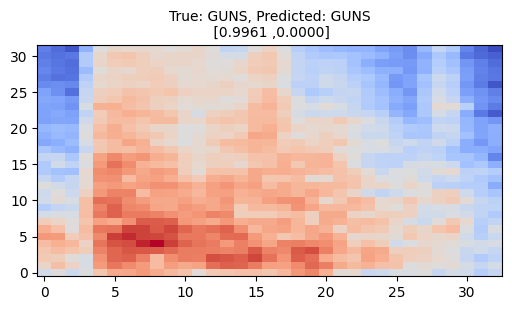

In [5]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_images):

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_images), 2), dtype=np.float32)
    for i, test_image in enumerate(test_images):

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details["dtype"] == np.int8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        if output_details["dtype"] == np.int8:
            output = (output / 128 + 1) / 2

        predictions[i] = output[0][0]

    return predictions


# Change this to test a different image
test_image_index = np.random.randint(0, BATCH_SIZE)


## Helper function to test the models on one image
def test_model(tflite_file, test_image_index):

    # take one image from test dataset
    test_data = list(dataset.take(1).as_numpy_iterator())[0]
    test_image = test_data[0][test_image_index]
    test_label = test_data[1][test_image_index]
    predictions = run_tflite_model(tflite_file, [test_image])
    fig, ax = plt.subplots(1, figsize=(6, 3))
    plot_spectrogram(test_image, ax)
    plt.title(
        f"True: {labels[test_label.argmax()]}, Predicted: {labels[np.argmax(predictions[0])]}\n [{predictions[0,0]:0.4f} ,{predictions[0,1]:0.4f}]"
    )
    plt.show()


# test_model("model.tflite", test_image_index)
test_model("model_quant.tflite", test_image_index)

In [6]:
def evaluate_model(tflite_file):
    good = 0

    for test_data in dataset.as_numpy_iterator():
        test_images = test_data[0]
        test_labels = test_data[1].argmax(axis=1)
        predictions = run_tflite_model(tflite_file, test_images)
        good += np.sum(test_labels == np.argmax(predictions, axis=1))
    return good / dataset.cardinality().numpy() / BATCH_SIZE


print(f"Accuracy original:  {100*evaluate_model('model.tflite'):.3f}%")
print(f"Accuracy quantized: {100*evaluate_model('model_quant.tflite'):.3f}%")

Accuracy original:  99.069%
Accuracy quantized: 98.936%


In [7]:
def evaluate_wav(model, test_image):
    interpreter = tf.lite.Interpreter(model_path=model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details["dtype"] == np.int8:
        input_scale, input_zero_point = input_details["quantization"]
        test_image = test_image / input_scale + input_zero_point

    yp = []
    WIDTH = 33
    STRIDE = 4
    SLICES = test_image.shape[1] - WIDTH
    for n in range(0, SLICES, STRIDE):
        im = test_image[:, n : n + WIDTH]
        im = np.expand_dims(im, axis=0)  # Add batch dimension
        im = np.expand_dims(im, axis=-1)  # Add channels dimension

        interpreter.set_tensor(
            input_details["index"], im.astype(input_details["dtype"])
        )
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        if output_details["dtype"] == np.int8:
            output = (output / 128 + 1) / 2
        yp.append(np.squeeze(output))
    return np.array(yp)

/home/claes/VENV/tf_env/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Text(0.5, 0.98, 'StreamLit/police_arrest.wav')

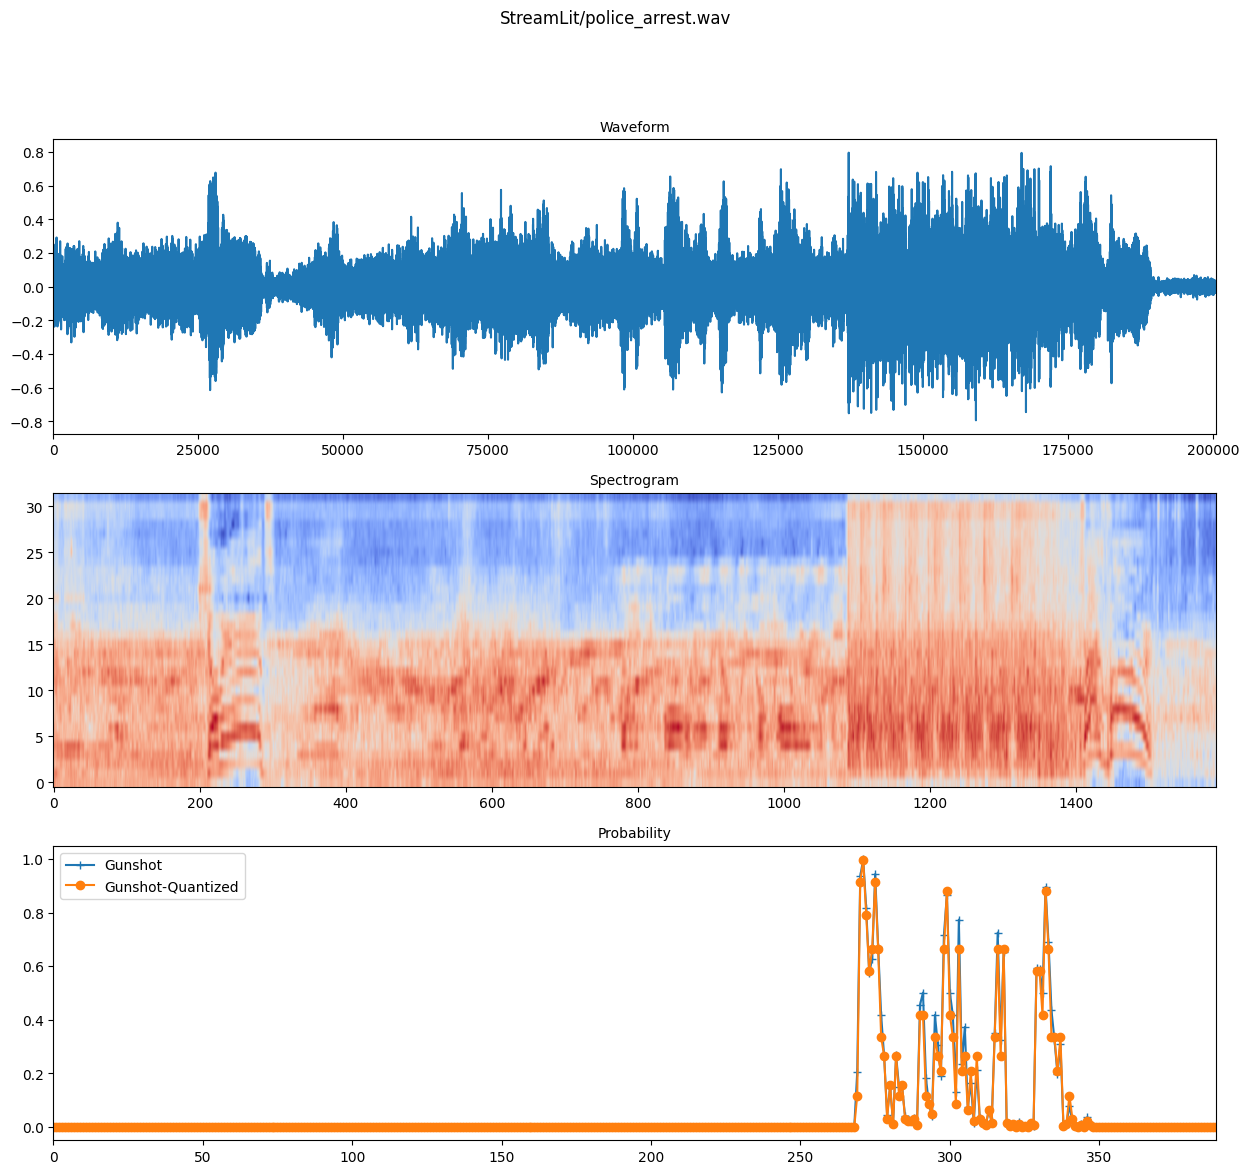

In [8]:
# fname = "StreamLit/city_2_shot_scene.wav"
# fname = "StreamLit/miami_street.wav"
# fname = "StreamLit/public_area_1.wav"
# fname = "StreamLit/public_area_2.wav"
fname = "StreamLit/police_arrest.wav"

sr_in0 = librosa.get_samplerate(fname)
data, sr_in = librosa.load(fname, sr=sr_in0, mono=True)
data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)

test_image = get_spectrogram(data)

yp_quant = evaluate_wav("model_quant.tflite", test_image)
yp_org = evaluate_wav("model.tflite", test_image)

fig, axes = plt.subplots(3, figsize=(15, 13))
timescale = np.arange(data.shape[0])
axes[0].plot(timescale, data)
axes[0].set_title("Waveform")

plot_spectrogram(test_image, axes[1])

axes[2].plot(yp_org[:, 0], label="Gunshot", marker="+")
axes[2].plot(yp_quant[:, 0], label="Gunshot-Quantized", marker="o")
axes[2].legend()
axes[2].set_title("Probability")
plt.suptitle(f"{fname}")